In [50]:
%%capture
from threeML import silence_logs
import warnings
warnings.filterwarnings("ignore")
silence_logs()
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
from astropy.time import Time
grbtime = Time("2012-07-11T02:44:53", format='isot', scale='utc')
#grbtime = "120711 024453" # works also

In [52]:
import numpy as np
ein = np.geomspace(20,800,300)
ebounds = np.geomspace(20,400,30)

In [53]:
from pyspi.utils.function_utils import find_response_version
from pyspi.utils.response.spi_response_data import ResponseDataRMF
version = find_response_version(grbtime)
print(version)
rsp_base = ResponseDataRMF.from_version(version)
4

4
Using the irfs that are valid between 10/05/27 12:45:00 and present (YY/MM/DD HH:MM:SS)


4

In [54]:
from pyspi.utils.response.spi_response import ResponseRMFGenerator
from pyspi.utils.response.spi_drm import SPIDRM
det=0
ra = 94.6783
dec = -70.99905
drm_generator = ResponseRMFGenerator.from_time(grbtime,
                                                det,
                                                ebounds,
                                                ein,
                                                rsp_base)
sd = SPIDRM(drm_generator, ra, dec)

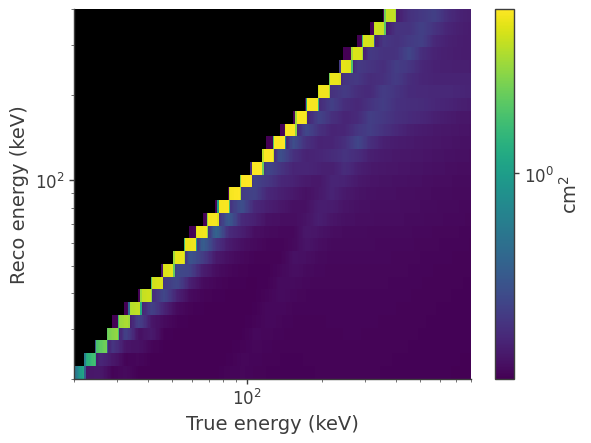

In [7]:
sd.plot_matrix();

In [55]:
from pyspi.utils.data_builder.time_series_builder import TimeSeriesBuilderSPI
tsb = TimeSeriesBuilderSPI.from_spi_grb(f"SPIDet{det}",
    det,
    grbtime,
    response=sd,
    sgl_type="both",
    )

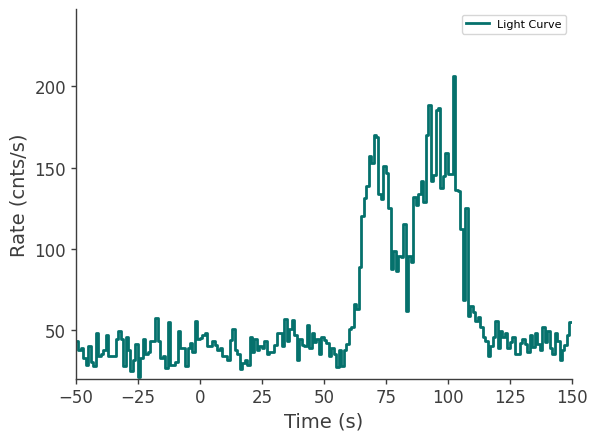

In [18]:
fig = tsb.view_lightcurve(-50,150)

In [19]:
active_time = "65-75"
bkg_time1 = "-500--10"
bkg_time2 = "150-1000"
tsb.set_active_time_interval(active_time)
tsb.set_background_interval(bkg_time1, bkg_time2)

Fitting Detector 0 background:   0%|                                                                          …

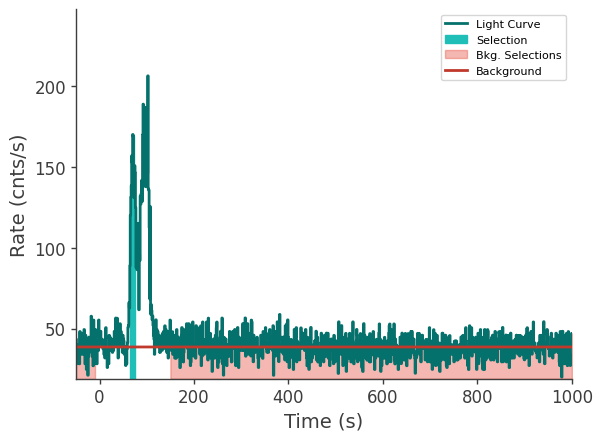

In [20]:
fig = tsb.view_lightcurve(-50,1000)

In [21]:
from pyspi.utils.livedets import get_live_dets
active_dets = get_live_dets(time=grbtime, event_types=["single"])
print(active_dets)

[ 0  3  4  6  7  8  9 10 11 12 13 14 15 16 18]


In [22]:
from pyspi.SPILike import SPILikeGRB
from threeML import DataList
spilikes = []
for d in active_dets:
    drm_generator = ResponseRMFGenerator.from_time(grbtime,
                                                    d,
                                                    ebounds,
                                                    ein,
                                                    rsp_base)
    sd = SPIDRM(drm_generator, ra, dec)
    tsb = TimeSeriesBuilderSPI.from_spi_grb(f"SPIDet{d}",
                                                d,
                                                grbtime,
                                                response=sd,
                                                sgl_type="both",
                                                )
    tsb.set_active_time_interval(active_time)
    tsb.set_background_interval(bkg_time1, bkg_time2)

    sl = tsb.to_spectrumlike()
    spilikes.append(SPILikeGRB.from_spectrumlike(sl,
                                                free_position=False))
datalist = DataList(*spilikes)

Fitting Detector 0 background:   0%|                                                                          …

Fitting Detector 3 background:   0%|                                                                          …

Fitting Detector 4 background:   0%|                                                                          …

Fitting Detector 6 background:   0%|                                                                          …

Fitting Detector 7 background:   0%|                                                                          …

Fitting Detector 8 background:   0%|                                                                          …

Fitting Detector 9 background:   0%|                                                                          …

Fitting Detector 10 background:   0%|                                                                         …

Fitting Detector 11 background:   0%|                                                                         …

Fitting Detector 12 background:   0%|                                                                         …

Fitting Detector 13 background:   0%|                                                                         …

Fitting Detector 14 background:   0%|                                                                         …

Fitting Detector 15 background:   0%|                                                                         …

Fitting Detector 16 background:   0%|                                                                         …

Fitting Detector 18 background:   0%|                                                                         …

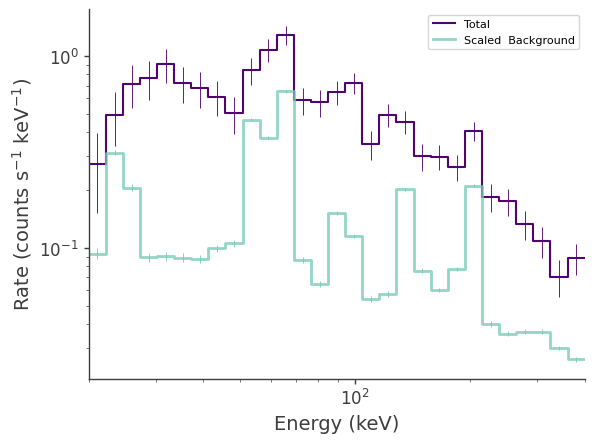

In [24]:
sl.view_count_spectrum();

In [19]:
from astromodels import *
pl = Powerlaw()
pl.K.prior = Log_uniform_prior(lower_bound=1e-6, upper_bound=1e4)
pl.K.bounds = (1e-6, 1e4)
pl.index.set_uninformative_prior(Uniform_prior)
pl.piv.value = 200
ps = PointSource('GRB',ra=ra, dec=dec, spectral_shape=pl)

model = Model(ps)

In [20]:
from threeML import BayesianAnalysis
ba_spi = BayesianAnalysis(model, datalist)
ba_spi.set_sampler("emcee", share_spectrum=True)
ba_spi.sampler.setup(n_walkers=20, n_iterations=500)
ba_spi.sample()

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw.K,(2.29 +/- 0.04) x 10^-2,1 / (cm2 keV s)
GRB.spectrum.main.Powerlaw.index,-1.005 -0.017 +0.019,


Values of -log(posterior) at the minimum:

,-log(posterior)
SPIDet0,-77.658997
SPIDet10,-62.705240
SPIDet11,-66.756127
SPIDet12,-65.657154
SPIDet13,-81.313254
SPIDet14,-71.225757
SPIDet15,-60.866649
SPIDet16,-60.154833
SPIDet18,-72.868007
SPIDet3,-70.038357


Values of statistical measures:

,statistical measures
AIC,2025.375059
BIC,2033.497973
DIC,2130.899642
PDIC,1.923728


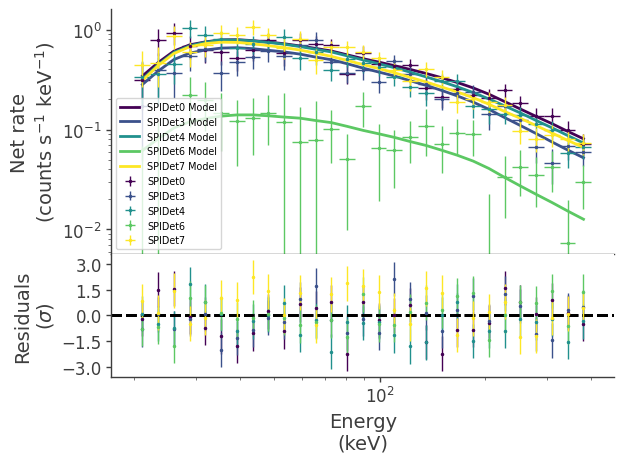

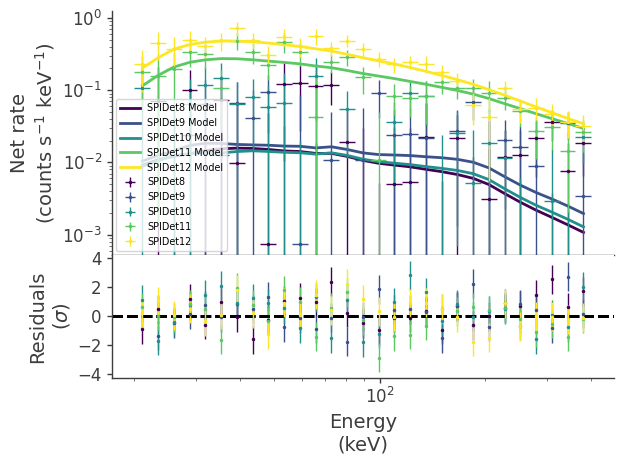

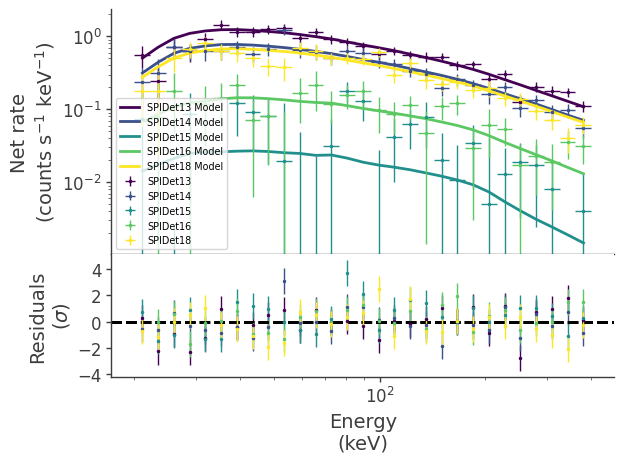

In [21]:
from threeML import display_spectrum_model_counts
fig = display_spectrum_model_counts(ba_spi,
                                data_per_plot=5,
                                source_only=True,
                                show_background=False,
                                model_cmap="viridis",
                                data_cmap="viridis",
                                background_cmap="viridis")

processing Bayesian analyses:   0%|                                                                           …

Propagating errors:   0%|                                                                                     …

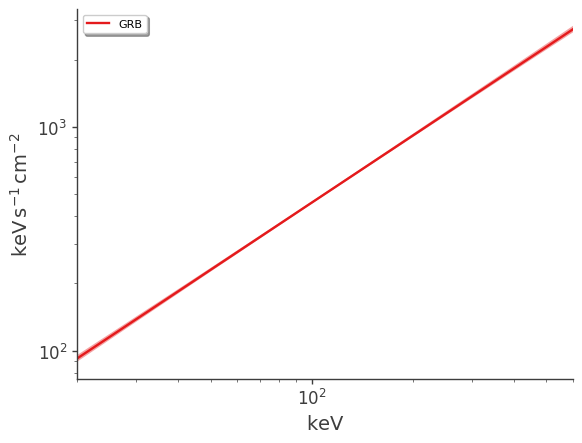

In [22]:
from threeML import plot_spectra
fig = plot_spectra(ba_spi.results, flux_unit="keV/(s cm2)", ene_min=20, ene_max=600)

In [ ]:
for s in spilikes:
    s.set_free_position(True)
datalist = DataList(*spilikes)

In [ ]:
import os
os.mkdir("./chains_grb_example")
ba_spi = BayesianAnalysis(model, datalist)
ba_spi.set_sampler("emcee")
ba_spi.sampler.setup(500,
                    chain_name='./chains_grb_example/docsfit1_',
                    resume=False,
                    verbose=False)
ba_spi.sample()

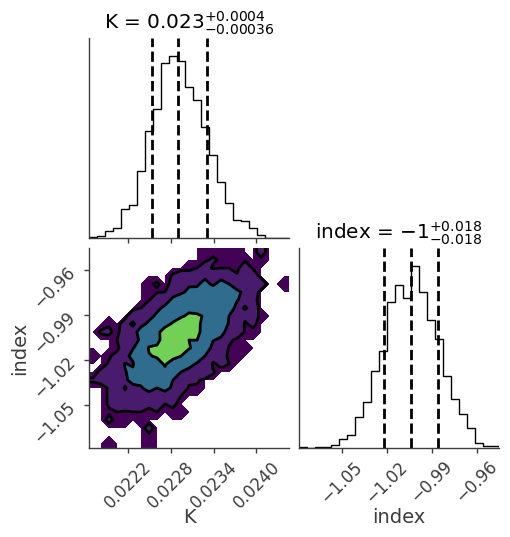

In [24]:
fig = ba_spi.results.corner_plot()